In [1]:
! pip install --upgrade cka-pytorch

  Attempting uninstall: cka-pytorch
    Found existing installation: cka-pytorch 0.1.5
    Uninstalling cka-pytorch-0.1.5:
      Successfully uninstalled cka-pytorch-0.1.5


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18
from tqdm.autonotebook import tqdm
from copy import deepcopy

/var/folders/9t/0nqj876j5299tnv1hzm4vp9r0000gn/T/ipykernel_17573/2226080857.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: mps


## Setup DataLoader and Models

An important detail is that although we are using the Validation set for `CIFAR10`, we **shuffle** and drop the last batch. This is to ensure that 1) the batches of each epoch are mixed, and 2) each iteration has the same batch size.

In [3]:
transforms = Compose(
    [
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

dataset = CIFAR10(root="./", train=False, download=True, transform=transforms)
dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [4]:
model1 = resnet18(pretrained=True).to(device)
model2 = deepcopy(model1).to(device)
model1.eval()
model2.eval()
print("Dummy models created")

Dummy models created


/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Compute CKA

In [5]:
from cka_pytorch import CKACalculator

### Basic Usage

In [6]:
calculator = CKACalculator(
    model1=model1,
    model2=model2,
    model1_name="ResNet18",
    model2_name="ResNet18",
    hook_recursive=False,
)

Now we can calculate the CKA matrix

In [7]:
cka_output = calculator.calculate_cka_matrix(dataloader)
print(f"CKA output size: {cka_output.size()}")

Calculate CKA matrix (Epoch 1/10):   0%|          | 0/39 [00:00<?, ?it/s]/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Calculate CKA matrix (Epoch 10/10): 100%|██████████| 39/39 [00:01<00:00, 27.88it/s]

CKA output size: torch.Size([10, 10])


Extract hooked module names. By default, all layers will be hooked.

In [8]:
for i, name in enumerate(calculator.hook_manager1.module_names):
    print(f"Layer {i}: \t{name}")

Layer 0: 	conv1
Layer 1: 	bn1
Layer 2: 	relu
Layer 3: 	maxpool
Layer 4: 	layer1
Layer 5: 	layer2
Layer 6: 	layer3
Layer 7: 	layer4
Layer 8: 	avgpool
Layer 9: 	fc


#### Visualize the output

Note that the returned matrix has its origin at the top left. In most papers, the CKA matrix is visualized with its origin at the bottom left. Thus, we may flip the matrix first before visualization; however, this example chooses not to.

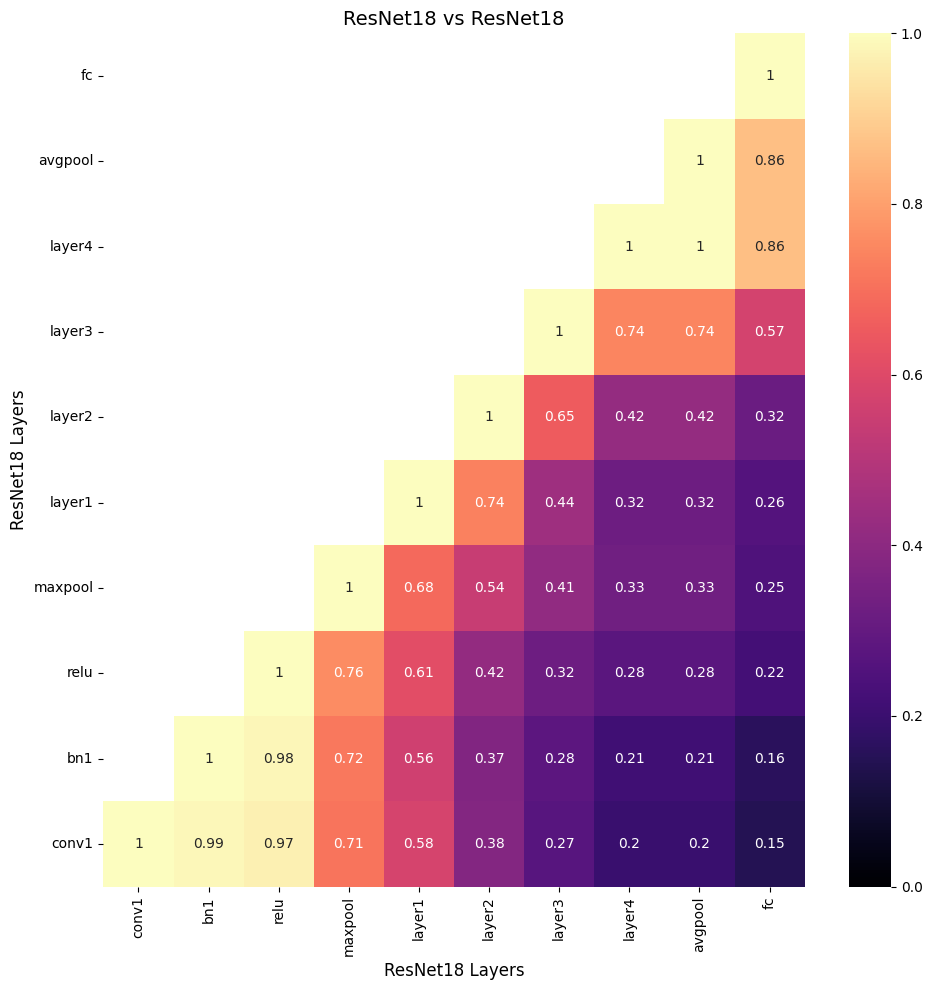

In [9]:
calculator.plot_cka_matrix(
    cka_output,
    show_half_heatmap=True,
    invert_y_axis=True,
    show_annotations=True,
)

### Advanced Usage

We can customize other parameters of the `CKACalculator`.
Most importantly, we can select which modules to hook.

Before instantiating a new instance of `CKACalculator` on, make sure to first call the `reset` method.
This clears all hooks registered in the models.

In [10]:
# Reset calculator to clear hooks
calculator.reset()
torch.cuda.empty_cache()

In [11]:
layers = ["conv1", "bn1"]

In [13]:
calculator = CKACalculator(
    model1=model1,
    model2=model2,
    model1_layers=layers,
    model2_layers=layers,
    model1_name="ResNet18",
    model2_name="ResNet18",
)

In [14]:
cka_output = calculator.calculate_cka_matrix(dataloader)
print(f"CKA output size: {cka_output.size()}")

Calculate CKA matrix (Epoch 1/10):   0%|          | 0/39 [00:00<?, ?it/s]/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Calculate CKA matrix (Epoch 10/10): 100%|██████████| 39/39 [00:01<00:00, 22.11it/s]

CKA output size: torch.Size([18, 18])


#### Visualize output

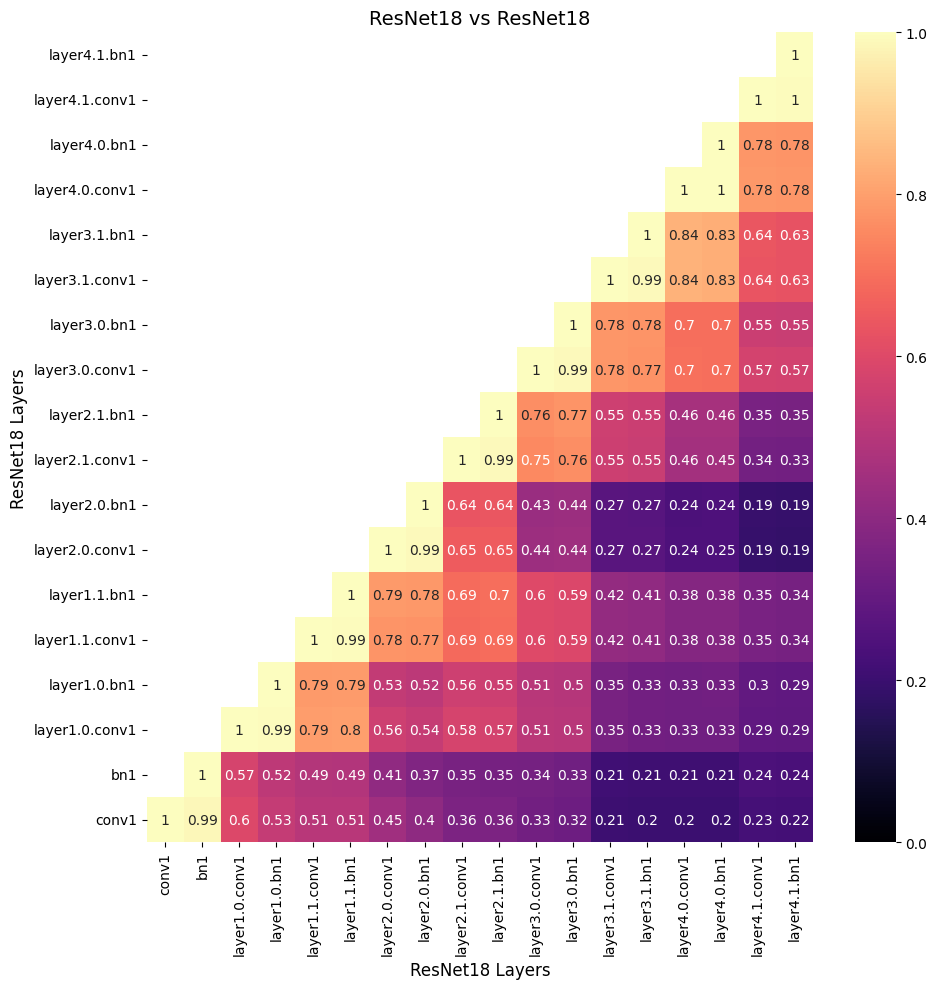

In [15]:
calculator.plot_cka_matrix(
    cka_output,
    show_half_heatmap=True,
    invert_y_axis=True,
    show_annotations=True,
)

In [16]:
calculator.reset()
torch.cuda.empty_cache()

### Fabric Support

`CKACalculator` also supports Fabric wrapped modules.

In [17]:
from lightning.fabric import Fabric

In [18]:
fabric = Fabric()
fabric.launch()

In [19]:
dataloader = fabric.setup_dataloaders(dataloader)
model1 = resnet18(pretrained=True)
model2 = deepcopy(model1)
model1 = fabric.setup_module(model1)
model2 = fabric.setup_module(model2)
model1.eval()
model2.eval()
print("Dummy models created")

/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dummy models created


In [20]:
calculator = CKACalculator(
    model1=model1,
    model2=model2,
    model1_name="ResNet18",
    model2_name="ResNet18",
    hook_recursive=False,
)

In [21]:
cka_output = calculator.calculate_cka_matrix(dataloader)
print(f"CKA output size: {cka_output.size()}")

Calculate CKA matrix (Epoch 1/10):   0%|          | 0/39 [00:00<?, ?it/s]/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Calculate CKA matrix (Epoch 10/10): 100%|██████████| 39/39 [00:01<00:00, 27.76it/s]

CKA output size: torch.Size([10, 10])


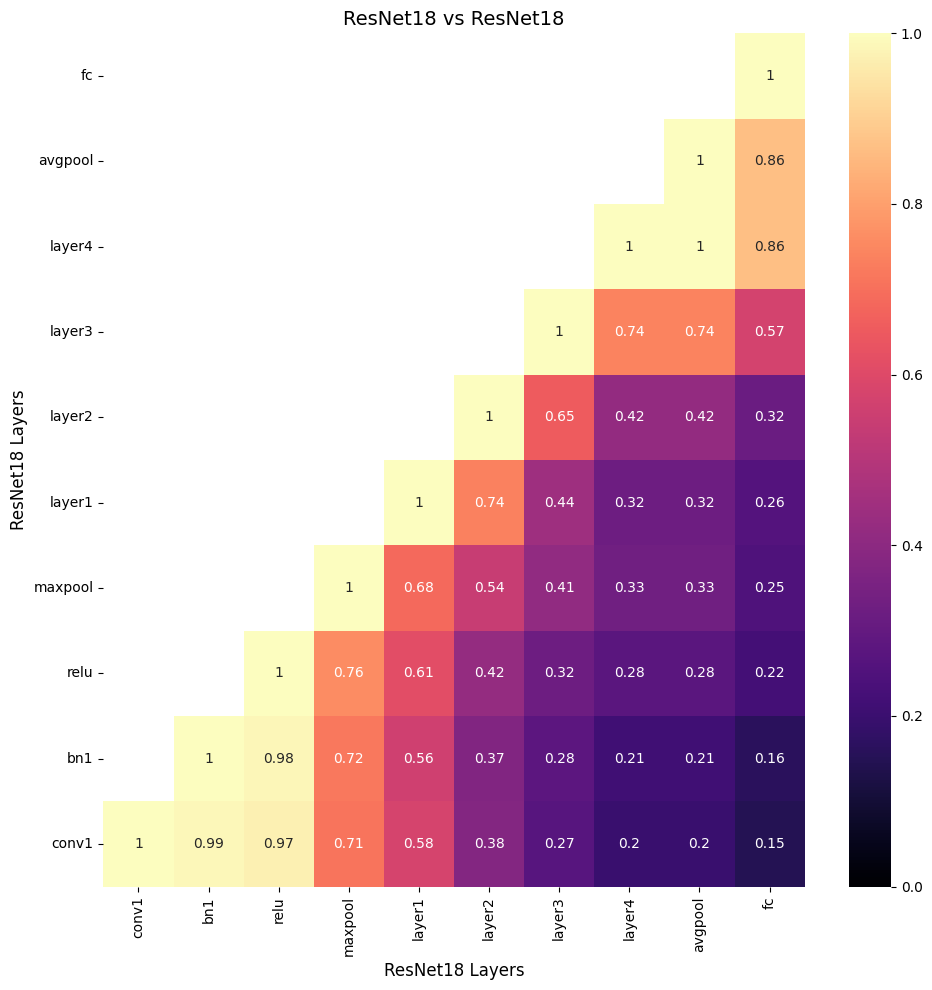

In [22]:
calculator.plot_cka_matrix(
    cka_output,
    show_half_heatmap=True,
    invert_y_axis=True,
    show_annotations=True,
)